In [7]:
!pip install numpy

In [8]:
!pip install matplotlib

In [9]:
!pip install tensorflow

In [10]:
!pip install ipython

In [13]:
!pip install -q -U keras-tuner

In [14]:
!pip install pyyaml h5py 

In [93]:
import numpy as np
import os
import PIL
import PIL.Image
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import pathlib
import shutil
import tempfile
from IPython import display

In [94]:
import keras_tuner as kt

In [95]:
print(os.getcwd())
# Change current directoru to dataset folder structure directory
os.chdir('D:\Load_Data_Category_32')
print(os.getcwd())
# class names
class_names=os.listdir() 
# no of classes
num_class= len(class_names)
print(class_names)
print(num_class)

D:\Load_Sample_32
D:\Load_Data_Category_32
['Blazer_Et_Veste_Formelle', 'Body', 'Bombers_Et_Blouson', 'Caban', 'Cape_Et_Poncho', 'Chemise', 'Combinaison', 'Coupe_Vent_Et_Veste_De_Pluie', 'Doudoune', 'Duffle_Coat', 'Gilet', 'Jupe', 'Manteau', 'Pantalon', 'Parka', 'Perfecto', 'Polo', 'Pull', 'Robe', 'Salopette', 'Short', 'Sweatshirt', 'Tops_Matiere_Droite', 'Tops_Matiere_Fluide', 'Trench', 'Veste_Sportswear', 'Veste_Urbaine_Et_Casual']
27


In [96]:
img_height=32
img_width=32
batch_size=32
epochs=10

In [97]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.getcwd(),
    labels='inferred',
    label_mode='int',
    class_names= class_names,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_width,img_width),
    shuffle=True,
    seed=10,
    validation_split=0.1,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 110350 files belonging to 27 classes.
Using 99315 files for training.


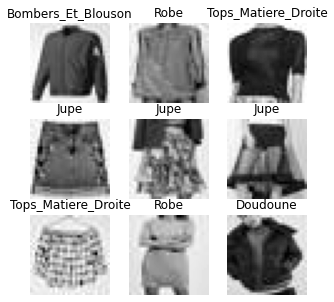

In [98]:
plt.figure(figsize=(5,5))
for image, label in train_ds.take(1):
    for x in range(9):
        ax=plt.subplot(3, 3, x+1)
        plt.imshow(image[x].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[label[x].numpy()])
        plt.axis("off")
plt.show()

In [99]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    os.getcwd(),
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=10,
    validation_split=0.1,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 110350 files belonging to 27 classes.
Using 11035 files for validation.


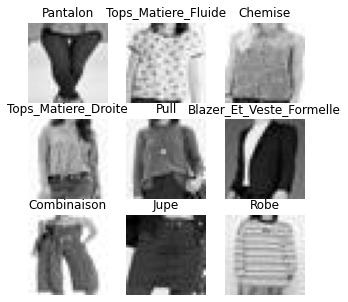

In [100]:
plt.figure(figsize=(5,5))
for image, label in validation_ds.take(1):
    for x in range(9):
        ax=plt.subplot(3, 3, x+1)
        plt.imshow(image[x].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[label[x].numpy()])
        plt.axis("off")
plt.show()

In [101]:
AUTOTUNE=tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [102]:
data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(input_shape=(img_height,img_width,1), mode='horizontal'),
            tf.keras.layers.RandomRotation(0.1),
])

In [103]:
def build_model(hp):
    
    units_1 = hp.Int('units_1',min_value=32, max_value=512, step=32)
    units_2 = hp.Int('units_2',min_value=32, max_value=512, step=32)
    units_3 = hp.Int('units_3',min_value=32, max_value=512, step=32)
    units_4 = hp.Int('units_4',min_value=32, max_value=512, step=32)
    
    units_5 = hp.Int('units_5',min_value=32, max_value=512, step=32)
    units_6 = hp.Int('units_6',min_value=32, max_value=512, step=32)
    
    dropout_1 = hp.Boolean('dropout_1')
    dropout_2 = hp.Boolean('dropout_2')
    dropout_3 = hp.Boolean('dropout_3')
    
    lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model = tf.keras.Sequential()
    model.add(data_augmentation)
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)))
    model.add(tf.keras.layers.Conv2D(units_1, 3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(units_2, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    if dropout_1:
        model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(units_3, 3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(units_4, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    if dropout_2:
        model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=units_5, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    if dropout_3:
        model.add(tf.keras.layers.Dropout(0.2)) 
    model.add(tf.keras.layers.Dense(units=units_6, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(tf.keras.layers.Dense(num_class, activation='softmax'))
    
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    )
    
    return model

In [104]:
build_model(kt.HyperParameters())

In [105]:
tuner=kt.RandomSearch(
                  hypermodel=build_model,
                  objective="val_accuracy",
                  max_trials=3,
                  executions_per_trial=2,
                  overwrite=True,
                  directory='D:\Robotics\Tuner_Results',
                  project_name="helloworld",
)

In [106]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_6 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_1 (Boolean)
{'default': False, 'conditions': []}
dropout_2 (Boolean)
{'default': False, 'conditions': []}
dropout_3 (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01,

In [107]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [108]:
tuner.search(train_ds, epochs=5, validation_data = validation_ds, callbacks=[stop_early])
#best_hps=tuner.get_best_hyperparameters(num_trails=1)[0]



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |?                 |units_1
160               |?                 |units_2
480               |?                 |units_3
352               |?                 |units_4
192               |?                 |units_5
352               |?                 |units_6
False             |?                 |dropout_1
True              |?                 |dropout_2
True              |?                 |dropout_3
0.0004443         |?                 |lr

Epoch 1/5
 464/3104 [===>..........................] - ETA: 22:26 - loss: 2.4830 - accuracy: 0.2682

KeyboardInterrupt: 

In [90]:
models=tuner.get_best_models(num_models=2)
best_model=models[0]
best_model.build(input_shape=(None, img_height, img_width))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 192)       110784    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 192)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 192)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 224)       387296    
                                                        

In [91]:
tuner.results_summary()

Results summary
Results in D:\Robotics\Tuner_Results\helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
units_1: 64
units_2: 192
units_3: 224
units_4: 64
units_5: 128
units_6: 128
dropout_1: True
dropout_2: True
dropout_3: True
lr: 0.001036847203444838
Score: 0.7862595319747925
Trial summary
Hyperparameters:
units_1: 64
units_2: 384
units_3: 448
units_4: 416
units_5: 192
units_6: 192
dropout_1: True
dropout_2: False
dropout_3: False
lr: 0.00010817592814403872
Score: 0.7824427485466003
Trial summary
Hyperparameters:
units_1: 224
units_2: 32
units_3: 320
units_4: 128
units_5: 64
units_6: 416
dropout_1: True
dropout_2: False
dropout_3: False
lr: 0.0004632926172814754
Score: 0.7748091518878937


In [ ]:
'''
print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

'''